In [84]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [22]:
def parse_dat_file_to_dataframe(file_path):
    # List to store event data (each event is a dict)
    events_data = []
    current_event = {}
    event_number = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing spaces
            
            # Detect the start of a new event
            event_match = re.match(r'% Event (\d+)', line)
            if event_match:
                # If we are in the middle of an event, store it before moving to the next one
                if current_event:
                    events_data.append(current_event)
                    current_event = {}
                
                # Start a new event
                event_number = int(event_match.group(1))
                current_event['Event'] = event_number
            
            # Split the key-value pairs and store them in the current_event dict
            elif line and not line.startswith('%'):
                key_value = line.split('\t')
                if len(key_value) == 2:
                    key, value = key_value
                    current_event[key] = float(value) if value.replace('.', '', 1).isdigit() else value

        # Append the last event after reading the file
        if current_event:
            events_data.append(current_event)
    
    # Convert list of event dictionaries to a DataFrame
    df = pd.DataFrame(events_data)
    
    return df

In [102]:
folder = "O:/Nat_ASVAP/OMLAB_DATA/ASVAP_press_"
month = "Sept2024/"
run = "Run-025"

start_file = 3
path_intial = folder+month+run+f"/Run-025-00{start_file}.dat"
path = folder+month+run
num_files = 80

In [103]:
df = parse_dat_file_to_dataframe(path_intial)
for i in range(start_file+1,num_files+1):
    
    if i <10:
        next_file = parse_dat_file_to_dataframe(path+f"/Run-025-00{i}.dat")
    elif 10 <= i <100:
        next_file = parse_dat_file_to_dataframe(path+f"/Run-025-0{i}.dat")
    elif 100 <= i:
        next_file = parse_dat_file_to_dataframe(path+f"/Run-025-{i}.dat")
    df = pd.concat([df,next_file],ignore_index=True)
zero_indices = df.index[df['Some_calibration'] == 0.0].tolist()
df = df.drop(index=zero_indices).reset_index(drop=True)

In [107]:
def linfunc(x, a, b):
    return x*a + b

def expfunc(x, a, b ,c):
    return a* np.exp( b * x) + c

xdata = ((df["Time_ms"]-df["Time_ms"][0])*2.7778*10**(-7)) #Time in hours
ydata = df["TC_CH4_Chbot_C"]
popt, pcov = curve_fit(expfunc, xdata, ydata)
popt

array([20.58993224, -3.59824828, -0.39648046])

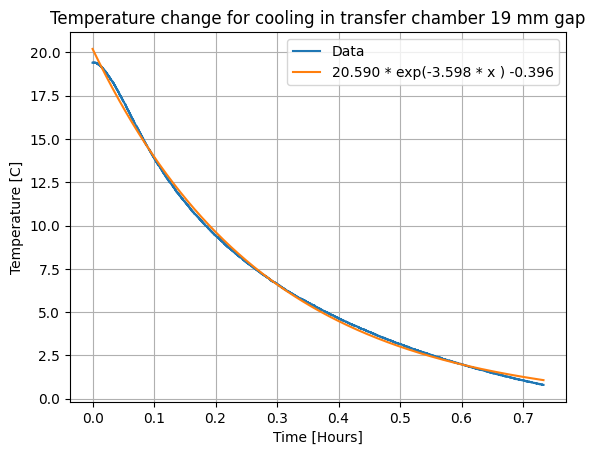

In [122]:
plt.plot(((df["Time_ms"]-df["Time_ms"][0])*2.7778*10**(-7)),df["TC_CH4_Chbot_C"], label="Data")
plt.plot(xdata, expfunc(xdata,*popt), label="{:.3f} * exp({:.3f} * x ) {:.3f}".format(*popt))
plt.xlabel("Time [Hours]")
plt.ylabel("Temperature [C]")
plt.grid()
plt.legend()
plt.title("Temperature change for cooling in transfer chamber 19 mm gap")
# plt.savefig("Temp Change")